## Model Development    

We set our goal as the ML/DL algorithm that can predict the probability that someone will be hspitalized following the release from a hospital stay within 30 days, 60 days, and 90 days. We have by far completed the following(in sequence):   
1. Developed the hypothesis  
2. Identified the tables that contain the data that will help us solve the business problem   
3. Completed exploratory data analysis to understand the data   
4. Completed identified and built the features.   

We now have data that is ready to be used for machine learning. A few minor tweaks may be required but not much. The focus of this section is to purely build the machine learning algorithm.   

**Here is the best part:** This step is much easier compared to the previous ones. Most of the AI tools are really good at this. We will use Github Copilot to write the code for us. There will be some back and forths. In fact, in writing the following code, there were so many back and forths. I encountered errors which can be easily solved by interacting with the models using your intuition and understanding of deep learning algorithms. 

Now we have the input and output values in the array form. Let us use my favorite deep learning library, PyTorch. 

### 30 Day Readmission Prediction   

Epoch 001 — Val AUC: 0.7331
Epoch 002 — Val AUC: 0.7594
Epoch 003 — Val AUC: 0.7734
Epoch 004 — Val AUC: 0.7861
Epoch 005 — Val AUC: 0.7910
Epoch 006 — Val AUC: 0.7960
Epoch 007 — Val AUC: 0.8000
Epoch 008 — Val AUC: 0.8047
Epoch 009 — Val AUC: 0.8063
Epoch 010 — Val AUC: 0.8055
Epoch 011 — Val AUC: 0.8064
Epoch 012 — Val AUC: 0.8094
Epoch 013 — Val AUC: 0.8111
Epoch 014 — Val AUC: 0.8103
Epoch 015 — Val AUC: 0.8133
Epoch 016 — Val AUC: 0.8152
Epoch 017 — Val AUC: 0.8139
Epoch 018 — Val AUC: 0.8144
Epoch 019 — Val AUC: 0.8161
Epoch 020 — Val AUC: 0.8170
Epoch 021 — Val AUC: 0.8167
Epoch 022 — Val AUC: 0.8168
Epoch 023 — Val AUC: 0.8190
Epoch 024 — Val AUC: 0.8164
Epoch 025 — Val AUC: 0.8200
Epoch 026 — Val AUC: 0.8172
Epoch 027 — Val AUC: 0.8189
Epoch 028 — Val AUC: 0.8158
Epoch 029 — Val AUC: 0.8191
Epoch 030 — Val AUC: 0.8208
Epoch 031 — Val AUC: 0.8184
Epoch 032 — Val AUC: 0.8188
Epoch 033 — Val AUC: 0.8160
Epoch 034 — Val AUC: 0.8199
Epoch 035 — Val AUC: 0.8178
Epoch 036 — Val AUC:

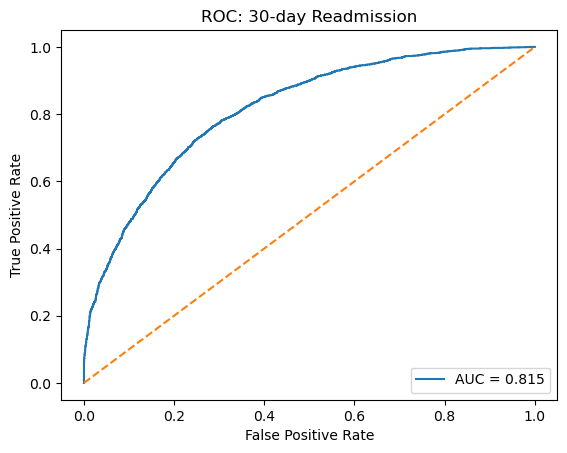

Confusion Matrix (rows=true, cols=pred):
[[7414  580]
 [1222  838]]
Precision: 0.5910
Recall:    0.4068
F1 Score:  0.4819


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ─── 1. Load & clean ─────────────────────────────────────────────────────────────
df = pd.read_csv(
    '../data/processed/features_final_df.csv'
)

# 1a) Drop any rows where our label is missing
df = df.dropna(subset=['readmit_30d'])

# 1b) Separate out label & inputs
y = df['readmit_30d'].astype(float).values.reshape(-1, 1)    # shape (N,1)
X = df.drop(columns=[
    'subject_id','hadm_id',
    'readmit_30d','readmit_60d','readmit_90d'
]).values                                                   # shape (N, D)

# 1c) Impute missing feature values (mean for numeric, 0 for bool)
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# ─── 2. Train/Val/Test split ──────────────────────────────────────────────────────
SEED = 42
# 70 / 15 / 15 split, stratify on the binary label
X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.1765, random_state=SEED, stratify=y_trval
)

# ─── 3. Scale inputs ──────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ─── 4. Build DataLoaders ─────────────────────────────────────────────────────────
BATCH_SIZE = 256

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)
val_ds   = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float()
)
test_ds  = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ─── 5. Model (BatchNorm + LeakyReLU) ─────────────────────────────────────────────
class ReadmitNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),            # combats vanishing
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)                # single logit
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ReadmitNet(X_train.shape[1]).to(device)

# ─── 6. Loss & optimizer (lower LR) ───────────────────────────────────────────────
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ─── 7. Training loop with grad clipping & AUC-based early stopping ─────────────
best_auc = 0.0
patience, max_patience = 0, 10

for epoch in range(1, 101):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        # ← clip any exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # — validation pass —
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            all_logits.append(model(xb).cpu().numpy())
            all_targets.append(yb.numpy())

    logits_np = np.vstack(all_logits)
    probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
    y_val_np  = np.vstack(all_targets).ravel()

    # mask out any NaN/Inf (should be none after imputation, but safe)
    mask = np.isfinite(probs_np) & np.isfinite(y_val_np)
    y_clean = y_val_np[mask]
    p_clean = probs_np[mask]

    # skip if too few samples or only one class
    if y_clean.size < 2 or len(np.unique(y_clean)) < 2:
        print(f"Epoch {epoch:03d}: insufficient class variety → skipping AUC")
        continue

    auc_val = roc_auc_score(y_clean, p_clean)
    print(f"Epoch {epoch:03d} — Val AUC: {auc_val:.4f}")

    if auc_val > best_auc + 1e-4:
        best_auc = auc_val
        torch.save(model.state_dict(), 'best_30d.pt')
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print(f"Early stopping at epoch {epoch}. Best AUC={best_auc:.4f}")
            break

# ─── 8. Test evaluation & ROC curve ───────────────────────────────────────────────
model.load_state_dict(torch.load('best_30d.pt'))
model.eval()
all_logits, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        all_logits.append(model(xb.to(device)).cpu().numpy())
        all_targets.append(yb.numpy())

logits_np = np.vstack(all_logits)
probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
y_test_np = np.vstack(all_targets).ravel()

mask   = np.isfinite(probs_np) & np.isfinite(y_test_np)
y_clean, p_clean = y_test_np[mask], probs_np[mask]

auc_test = roc_auc_score(y_clean, p_clean)
print(f"30-day Readmit Test AUC: {auc_test:.4f}")

fpr, tpr, _ = roc_curve(y_clean, p_clean)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: 30-day Readmission')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix & classification metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = (p_clean >= 0.5).astype(int)

cm = confusion_matrix(y_clean, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

precision = precision_score(y_clean, y_pred)
recall    = recall_score(y_clean, y_pred)
f1        = f1_score(y_clean, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



### 60 Day Readmission Prediction   

Epoch 001 — Val AUC: 0.7486
Epoch 002 — Val AUC: 0.7769
Epoch 003 — Val AUC: 0.7922
Epoch 004 — Val AUC: 0.8012
Epoch 005 — Val AUC: 0.8087
Epoch 006 — Val AUC: 0.8089
Epoch 007 — Val AUC: 0.8130
Epoch 008 — Val AUC: 0.8141
Epoch 009 — Val AUC: 0.8169
Epoch 010 — Val AUC: 0.8188
Epoch 011 — Val AUC: 0.8216
Epoch 012 — Val AUC: 0.8233
Epoch 013 — Val AUC: 0.8259
Epoch 014 — Val AUC: 0.8256
Epoch 015 — Val AUC: 0.8291
Epoch 016 — Val AUC: 0.8285
Epoch 017 — Val AUC: 0.8308
Epoch 018 — Val AUC: 0.8297
Epoch 019 — Val AUC: 0.8325
Epoch 020 — Val AUC: 0.8346
Epoch 021 — Val AUC: 0.8349
Epoch 022 — Val AUC: 0.8352
Epoch 023 — Val AUC: 0.8374
Epoch 024 — Val AUC: 0.8374
Epoch 025 — Val AUC: 0.8375
Epoch 026 — Val AUC: 0.8412
Epoch 027 — Val AUC: 0.8403
Epoch 028 — Val AUC: 0.8403
Epoch 029 — Val AUC: 0.8392
Epoch 030 — Val AUC: 0.8411
Epoch 031 — Val AUC: 0.8382
Epoch 032 — Val AUC: 0.8392
Epoch 033 — Val AUC: 0.8426
Epoch 034 — Val AUC: 0.8430
Epoch 035 — Val AUC: 0.8424
Epoch 036 — Val AUC:

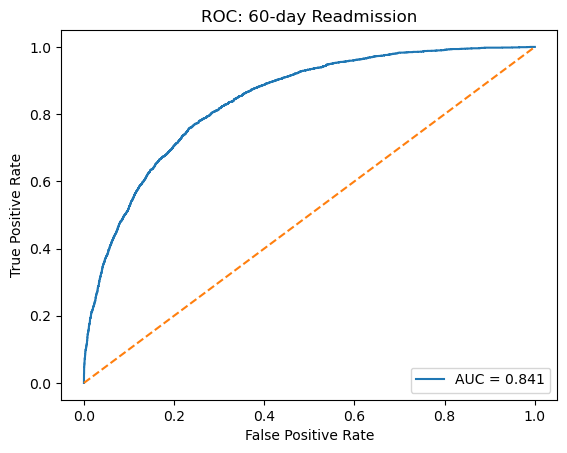

Confusion Matrix (rows=true, cols=pred):
[[6315 1028]
 [1035 1676]]
Precision: 0.6198
Recall:    0.6182
F1 Score:  0.6190


In [ ]:

# ─── 1. Load & clean ─────────────────────────────────────────────────────────────
df = pd.read_csv(
    '../data/processed/features_final_df.csv'
)

# 1a) Drop any rows where our label is missing
df = df.dropna(subset=['readmit_60d'])

# 1b) Separate out label & inputs
y = df['readmit_60d'].astype(float).values.reshape(-1, 1)    # shape (N,1)
X = df.drop(columns=[
    'subject_id','hadm_id',
    'readmit_30d','readmit_60d','readmit_90d'
]).values                                                   # shape (N, D)

# 1c) Impute missing feature values (mean for numeric, 0 for bool)
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# ─── 2. Train/Val/Test split ──────────────────────────────────────────────────────
SEED = 42
# 70 / 15 / 15 split, stratify on the binary label
X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.1765, random_state=SEED, stratify=y_trval
)

# ─── 3. Scale inputs ──────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ─── 4. Build DataLoaders ─────────────────────────────────────────────────────────
BATCH_SIZE = 256

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)
val_ds   = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float()
)
test_ds  = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ─── 5. Model (BatchNorm + LeakyReLU) ─────────────────────────────────────────────
class ReadmitNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),            # combats vanishing
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)                # single logit
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ReadmitNet(X_train.shape[1]).to(device)

# ─── 6. Loss & optimizer (lower LR) ───────────────────────────────────────────────
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ─── 7. Training loop with grad clipping & AUC-based early stopping ─────────────
best_auc = 0.0
patience, max_patience = 0, 10

for epoch in range(1, 101):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        # ← clip any exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # — validation pass —
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            all_logits.append(model(xb).cpu().numpy())
            all_targets.append(yb.numpy())

    logits_np = np.vstack(all_logits)
    probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
    y_val_np  = np.vstack(all_targets).ravel()

    # mask out any NaN/Inf (should be none after imputation, but safe)
    mask = np.isfinite(probs_np) & np.isfinite(y_val_np)
    y_clean = y_val_np[mask]
    p_clean = probs_np[mask]

    # skip if too few samples or only one class
    if y_clean.size < 2 or len(np.unique(y_clean)) < 2:
        print(f"Epoch {epoch:03d}: insufficient class variety → skipping AUC")
        continue

    auc_val = roc_auc_score(y_clean, p_clean)
    print(f"Epoch {epoch:03d} — Val AUC: {auc_val:.4f}")

    if auc_val > best_auc + 1e-4:
        best_auc = auc_val
        torch.save(model.state_dict(), 'best_60d.pt')
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print(f"Early stopping at epoch {epoch}. Best AUC={best_auc:.4f}")
            break

# ─── 8. Test evaluation & ROC curve ───────────────────────────────────────────────
model.load_state_dict(torch.load('best_60d.pt'))
model.eval()
all_logits, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        all_logits.append(model(xb.to(device)).cpu().numpy())
        all_targets.append(yb.numpy())

logits_np = np.vstack(all_logits)
probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
y_test_np = np.vstack(all_targets).ravel()

mask   = np.isfinite(probs_np) & np.isfinite(y_test_np)
y_clean, p_clean = y_test_np[mask], probs_np[mask]

auc_test = roc_auc_score(y_clean, p_clean)
print(f"60-day Readmit Test AUC: {auc_test:.4f}")

fpr, tpr, _ = roc_curve(y_clean, p_clean)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: 60-day Readmission')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix & classification metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = (p_clean >= 0.5).astype(int)

cm = confusion_matrix(y_clean, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

precision = precision_score(y_clean, y_pred)
recall    = recall_score(y_clean, y_pred)
f1        = f1_score(y_clean, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Epoch 001 — Val AUC: 0.7441
Epoch 002 — Val AUC: 0.7744
Epoch 003 — Val AUC: 0.7872
Epoch 004 — Val AUC: 0.7968
Epoch 005 — Val AUC: 0.8027
Epoch 006 — Val AUC: 0.8061
Epoch 007 — Val AUC: 0.8110
Epoch 008 — Val AUC: 0.8144
Epoch 009 — Val AUC: 0.8159
Epoch 010 — Val AUC: 0.8211
Epoch 011 — Val AUC: 0.8200
Epoch 012 — Val AUC: 0.8258
Epoch 013 — Val AUC: 0.8243
Epoch 014 — Val AUC: 0.8277
Epoch 015 — Val AUC: 0.8295
Epoch 016 — Val AUC: 0.8327
Epoch 017 — Val AUC: 0.8337
Epoch 018 — Val AUC: 0.8349
Epoch 019 — Val AUC: 0.8343
Epoch 020 — Val AUC: 0.8378
Epoch 021 — Val AUC: 0.8381
Epoch 022 — Val AUC: 0.8388
Epoch 023 — Val AUC: 0.8389
Epoch 024 — Val AUC: 0.8388
Epoch 025 — Val AUC: 0.8412
Epoch 026 — Val AUC: 0.8440
Epoch 027 — Val AUC: 0.8428
Epoch 028 — Val AUC: 0.8443
Epoch 029 — Val AUC: 0.8449
Epoch 030 — Val AUC: 0.8440
Epoch 031 — Val AUC: 0.8439
Epoch 032 — Val AUC: 0.8455
Epoch 033 — Val AUC: 0.8475
Epoch 034 — Val AUC: 0.8473
Epoch 035 — Val AUC: 0.8462
Epoch 036 — Val AUC:

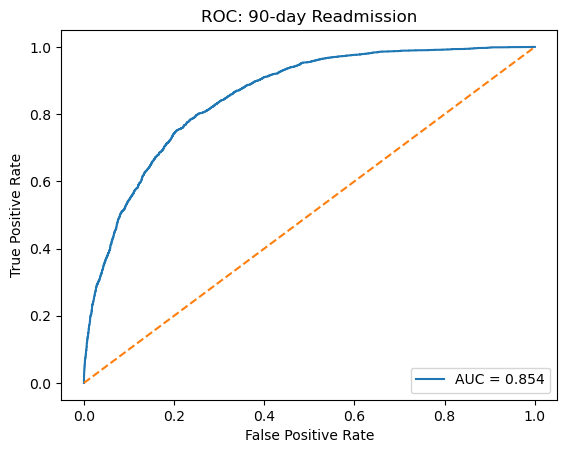

Confusion Matrix (rows=true, cols=pred):
[[5942 1008]
 [1109 1995]]
Precision: 0.6643
Recall:    0.6427
F1 Score:  0.6533


In [ ]:

# ─── 1. Load & clean ─────────────────────────────────────────────────────────────
df = pd.read_csv(
    '../data/processed/features_final_df.csv'
)

# 1a) Drop any rows where our label is missing
df = df.dropna(subset=['readmit_90d'])

# 1b) Separate out label & inputs
y = df['readmit_90d'].astype(float).values.reshape(-1, 1)    # shape (N,1)
X = df.drop(columns=[
    'subject_id','hadm_id',
    'readmit_30d','readmit_60d','readmit_90d'
]).values                                                   # shape (N, D)

# 1c) Impute missing feature values (mean for numeric, 0 for bool)
imp = SimpleImputer(strategy='mean')
X = imp.fit_transform(X)

# ─── 2. Train/Val/Test split ──────────────────────────────────────────────────────
SEED = 42
# 70 / 15 / 15 split, stratify on the binary label
X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.1765, random_state=SEED, stratify=y_trval
)

# ─── 3. Scale inputs ──────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

# ─── 4. Build DataLoaders ─────────────────────────────────────────────────────────
BATCH_SIZE = 256

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(y_train).float()
)
val_ds   = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).float()
)
test_ds  = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# ─── 5. Model (BatchNorm + LeakyReLU) ─────────────────────────────────────────────
class ReadmitNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),            # combats vanishing
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),

            nn.Linear(32, 1)                # single logit
        )
    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = ReadmitNet(X_train.shape[1]).to(device)

# ─── 6. Loss & optimizer (lower LR) ───────────────────────────────────────────────
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ─── 7. Training loop with grad clipping & AUC-based early stopping ─────────────
best_auc = 0.0
patience, max_patience = 0, 10

for epoch in range(1, 101):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        # ← clip any exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    # — validation pass —
    model.eval()
    all_logits, all_targets = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            all_logits.append(model(xb).cpu().numpy())
            all_targets.append(yb.numpy())

    logits_np = np.vstack(all_logits)
    probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
    y_val_np  = np.vstack(all_targets).ravel()

    # mask out any NaN/Inf (should be none after imputation, but safe)
    mask = np.isfinite(probs_np) & np.isfinite(y_val_np)
    y_clean = y_val_np[mask]
    p_clean = probs_np[mask]

    # skip if too few samples or only one class
    if y_clean.size < 2 or len(np.unique(y_clean)) < 2:
        print(f"Epoch {epoch:03d}: insufficient class variety → skipping AUC")
        continue

    auc_val = roc_auc_score(y_clean, p_clean)
    print(f"Epoch {epoch:03d} — Val AUC: {auc_val:.4f}")

    if auc_val > best_auc + 1e-4:
        best_auc = auc_val
        torch.save(model.state_dict(), 'best_90d.pt')
        patience = 0
    else:
        patience += 1
        if patience >= max_patience:
            print(f"Early stopping at epoch {epoch}. Best AUC={best_auc:.4f}")
            break

# ─── 8. Test evaluation & ROC curve ───────────────────────────────────────────────
model.load_state_dict(torch.load('best_90d.pt'))
model.eval()
all_logits, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        all_logits.append(model(xb.to(device)).cpu().numpy())
        all_targets.append(yb.numpy())

logits_np = np.vstack(all_logits)
probs_np  = torch.sigmoid(torch.from_numpy(logits_np)).numpy().ravel()
y_test_np = np.vstack(all_targets).ravel()

mask   = np.isfinite(probs_np) & np.isfinite(y_test_np)
y_clean, p_clean = y_test_np[mask], probs_np[mask]

auc_test = roc_auc_score(y_clean, p_clean)
print(f"90-day Readmit Test AUC: {auc_test:.4f}")

fpr, tpr, _ = roc_curve(y_clean, p_clean)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_test:.3f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: 90-day Readmission')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix & classification metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred = (p_clean >= 0.5).astype(int)

cm = confusion_matrix(y_clean, y_pred)
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)

precision = precision_score(y_clean, y_pred)
recall    = recall_score(y_clean, y_pred)
f1        = f1_score(y_clean, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")